In [ ]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [ ]:
epochs=10

device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()
])
train_data = datasets.CIFAR10(
    root = 'data',
    download = True,
    train = True,
    transform=transform
)
test_data = datasets.CIFAR10(
    root='data',
    download = True,
    train = False,
    transform=transform
)

train_loader = DataLoader(train_data,batch_size=2,shuffle=True)
test_loader = DataLoader(test_data,batch_size=2,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch
import torch.nn as nn

cfg = {
    'vgg16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'],
    'vgg19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

class VGG(nn.Module):

    def __init__(self, features, num_classes=10):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)

        return output

def make_layers(cfg):
    layers = []

    input_channel = 3
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

       
        layers += [nn.BatchNorm2d(l)]

        layers += [nn.ReLU(inplace=True)]
        input_channel = l

    return nn.Sequential(*layers)


def vgg16(num=10):
    return VGG(make_layers(cfg['vgg16']),num_classes=num)

def vgg19(num=10):
    return VGG(make_layers(cfg['vgg19']),num_classes=num)



In [ ]:
model = vgg16().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
train_accu = []
train_losses = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss=0
    correct=0
    total=0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step() 

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
   
    train_accu.append(accu)
    train_losses.append(train_loss)
    
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [ ]:
eval_losses=[]
eval_accu=[]

def test(model, device, test_loader):
    model.eval() 
    running_loss=0
    correct=0
    total=0
    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            running_loss += loss_fn(output, target).sum().item()
            pred = output.max(1, keepdim=True)[1]
            total += target.size(0)
            correct += pred.eq(target.view_as(pred)).sum().item() 

        test_loss = running_loss/len(test_loader.dataset)  
        accu=100.*correct/total
 
        eval_losses.append(test_loss)
        eval_accu.append(accu)
        print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
        print('-----------------------------------')

In [ ]:
for epoch in range(1, epochs+1):
  print(f"Epoch {epoch}")
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Epoch 1
Train Loss: nan | Accuracy: 10.004
Test Loss: nan | Accuracy: 10.000
-----------------------------------
Epoch 2
Train Loss: nan | Accuracy: 10.000
Test Loss: nan | Accuracy: 10.000
-----------------------------------
Epoch 3
Train Loss: nan | Accuracy: 10.000
Test Loss: nan | Accuracy: 10.000
-----------------------------------
Epoch 4
Train Loss: nan | Accuracy: 10.000
Test Loss: nan | Accuracy: 10.000
-----------------------------------
Epoch 5
Train Loss: nan | Accuracy: 10.000
Test Loss: nan | Accuracy: 10.000
-----------------------------------
Epoch 6
Train Loss: nan | Accuracy: 10.000
Test Loss: nan | Accuracy: 10.000
-----------------------------------
Epoch 7
Train Loss: nan | Accuracy: 10.000
Test Loss: nan | Accuracy: 10.000
-----------------------------------
Epoch 8
Train Loss: nan | Accuracy: 10.000
Test Loss: nan | Accuracy: 10.000
-----------------------------------
Epoch 9
Train Loss: nan | Accuracy: 10.000
Test Loss: nan | Accuracy: 10.000
-------------------

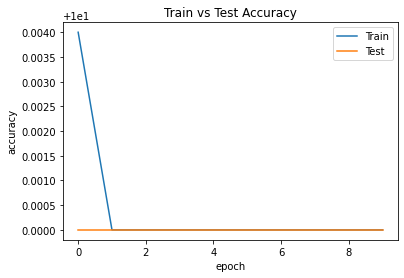

In [ ]:
import matplotlib.pyplot as plt


plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

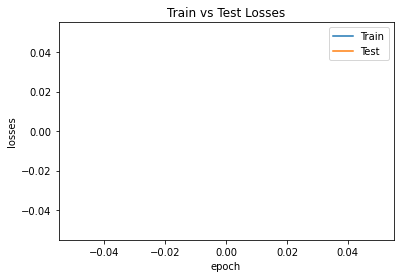

In [ ]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

In [ ]:
classes = ['airplane', 'automobile', 'bird','cat','deer', 'dog', 'frog','horse','ship','truck']

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device),target.to(device)
        outputs = model(data)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(target, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 100.0 %
Accuracy for class: automobile is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %
